# Graph Ektraksi Kata

## Crawl Detik

Program ini, "Detik News Scraper", dirancang untuk mengambil informasi dari situs detik.com terkait topik berita yang diinginkan. Pengguna memasukkan topik, program mengambil URL berita, dan kemudian ekstrak informasi seperti judul, penulis, tanggal, dan isi berita.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

class Detik:
    def __init__(self, topic):
        self.topic = topic
        self.df = None  # Inisialisasi DataFrame sebagai None

    def get_urls(self):
        news_links = []
        # get news URL from page 1
        page = 1
        url = f"https://www.detik.com/search/searchall?query={self.topic}&siteid=2&sortby=time&page={page}"
        html_page = requests.get(url).content
        soup = BeautifulSoup(html_page, 'lxml')
        articles = soup.find_all('article')

        # Ambil hanya satu URL berita, jika ada
        if articles:
            url = articles[0].find('a')['href']
            news_links.append(url)

        return news_links

    def has_link(self, text):
        # Fungsi untuk memeriksa apakah teks mengandung tautan
        return 'href=' in text

    def extract_news(self):
        # get news article details from scraped URLs
        scraped_info = []
        for news in self.get_urls():
            source = news
            html_page = requests.get(news).content
            soup = BeautifulSoup(html_page, 'lxml')
            # check if title, author, date, news div, is not None type
            title = soup.find('h1', class_='detail__title')
            if title is not None:
                title = title.text
                title = title.replace('\n', '')
                title = title.strip()

            author = soup.find('div', class_='detail__author')
            if author is not None:
                author = author.text

            date = soup.find('div', class_='detail__date')
            if date is not None:
                date = date.text

            # Ambil isi berita dari div dengan class 'detail__body-text itp_bodycontent'
            content_div = soup.find("div", {"class": "detail__body-text itp_bodycontent"})
            if content_div:
                # Hilangkan elemen-elemen <a> yang merupakan tautan
                for a_tag in content_div.find_all(self.has_link):
                    a_tag.decompose()

                # Ambil teks dari div
                news_content = ' '.join(content_div.stripped_strings)

                # convert scraped data into a dictionary
                news_data = {
                    "url": source,
                    "judul": title,
                    "penulis": author,
                    "tanggal": date,
                    "isi": news_content
                }
                # add dictionaries to a list
                scraped_info.append(news_data)

        self.df = pd.DataFrame.from_dict(scraped_info)
        self.df.to_csv(f'{self.topic}.csv', index=False)  # Simpan DataFrame ke dalam file CSV

# Input topik berita
topic = input("Masukkan topik berita yang ingin diambil: ")
detik_crawler = Detik(topic)
detik_crawler.extract_news()

# Setelah DataFrame df dibuat dalam metode extract_news, Anda dapat mengaksesnya di sini
detik_crawler.df



Masukkan topik berita yang ingin diambil: pemilu


,url,judul,penulis,tanggal,isi
0,https://www.detik.com/sumbagsel/berita/d-70533...,Bawaslu Babel Dapati ASN-Honorer Ikut Kegiatan...,Deni Wahyono - detikSumbagsel,"Kamis, 23 Nov 2023 20:34 WIB",Bangka - Badan Pengawas Pemilu (Bawaslu) Bangk...


## Ekstraksi kata

 fungsi build_co_occurrence_matrix, kata-kata yang muncul bersamaan dalam jendela setiap kata direkam dalam matriks co-occurrence. Nilai dalam matriks menunjukkan seberapa sering kata-kata tersebut muncul bersamaan.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Download stopwords dataset
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    # Hapus simbol dan angka menggunakan regular expression
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenisasi kata-kata
    words = word_tokenize(text)

    # Hapus stopwords
    words = [word for word in words if word.lower() not in stop_words]

    # Gabungkan kembali kata-kata yang sudah diolah
    processed_text = ' '.join(words)

    return processed_text

def build_co_occurrence_matrix(corpus, window_size):
    # Build unique words
    unique_words = set()
    for text in corpus:
        text = preprocess_text(text)
        for word in word_tokenize(text):
            unique_words.add(word)

    word_search_dict = {word: np.zeros(shape=(len(unique_words))) for word in unique_words}
    word_list = list(word_search_dict.keys())
    for text in corpus:
        text = preprocess_text(text)
        text_list = word_tokenize(text)
        for idx, word in enumerate(text_list):
            # Pick word in the size range
            i = max(0, idx - window_size)
            j = min(len(text_list) - 1, idx + window_size)
            search = [text_list[idx_] for idx_ in range(i, j + 1)]
            search.remove(word)
            for neighbor in search:
                # Get neighbor idx in word_search_dict
                nei_idx = word_list.index(neighbor)
                word_search_dict[word][nei_idx] += 1
    return word_search_dict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Ambil kolom 'isi' dari DataFrame sebagai corpus
corpus = detik_crawler.df['isi'].tolist()

# Tampilkan contoh dari corpus
print(corpus[:5])

['Bangka - Badan Pengawas Pemilu (Bawaslu) Bangka Belitung menerima laporan terkait ASN hingga honorer yang terlibat kegiatan partai politik. Pihaknya sedang mengusut laporan tersebut. "Yang paling urgent itu netralitas ASN, TNI dan Polri. Namun yang menjadi fokus kita tetap pada ASN, karena ada beberapa temuan dan laporan yang harus kita tindaklanjuti," kata Ketua Bawaslu Babel, EM Osykar usai apel siaga Pemilu 2024 di lapangan GOR Sahabuddin Babel, Kamis (23/11/2023). Osykar menerangkan bahwa pihaknya sudah menerima laporan dan temuan terkait itu. Padahal saat itu peserta Pemilu 2024 belum memasuki masa kampanye. ADVERTISEMENT SCROLL TO CONTINUE WITH CONTENT Bawaslu Babel mendapati adanya ASN dan honorer yang diduga terlibat dalam kegiatan partai politik secara langsung. "Yang pertama terkait keterlibatan ASN Provinsi pada salah satu kegiatan politik dari koalisi parpol. Mereka aktif menunggu dan ikut dalam kegiatan tersebut. Hasil pengamatan kami di lapangan, dia (ASN) aktif juga me

window_size dalam konteks ini adalah parameter yang menentukan seberapa jauh kata-kata dalam teks dianggap bersamaan dalam matriks co-occurrence. Nilai window_size menunjukkan jumlah kata sebelah kiri dan kanan dari kata target yang akan dihitung untuk setiap kemunculan kata tersebut.

Sebagai contoh, jika window_size disetel ke 1, hanya kata sebelah kiri dan kanan dari kata target yang akan dihitung. Dengan kata lain, hanya kata yang berdekatan dengan kata target yang akan dicatat sebagai co-occurrence.

In [ ]:
coo_dict=build_co_occurrence_matrix(corpus,window_size=1)

coo_dict

{'urgent': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 'Polri': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
coo_df = pd.DataFrame(coo_dict,index=coo_dict.keys()).astype('int')
coo_df

,urgent,Polri,apel,dukungan,Provinsi,feedback,akun,partai,Pemilu,Osykar,...,Puding,bermedia,Undangundang,TO,Kabupaten,ketidaktahuan,tahapan,Pemprov,Bawaslu,share
urgent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Polri,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apel,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
dukungan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Provinsi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ketidaktahuan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tahapan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pemprov,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bawaslu,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0


## Membentuk Graph

Graph yang menghubungkan kata per kata dari hasil matriks co-occurrence merupakan representasi visual dari hubungan antara kata-kata dalam teks berdasarkan seberapa sering kata-kata tersebut muncul bersamaan dalam suatu jendela yang ditentukan. Dalam konteks ini, setiap kata dalam teks direpresentasikan sebagai simpul (node) dalam graf, dan hubungan antar kata direpresentasikan oleh tepi (edge) berdasarkan matriks co-occurrence.

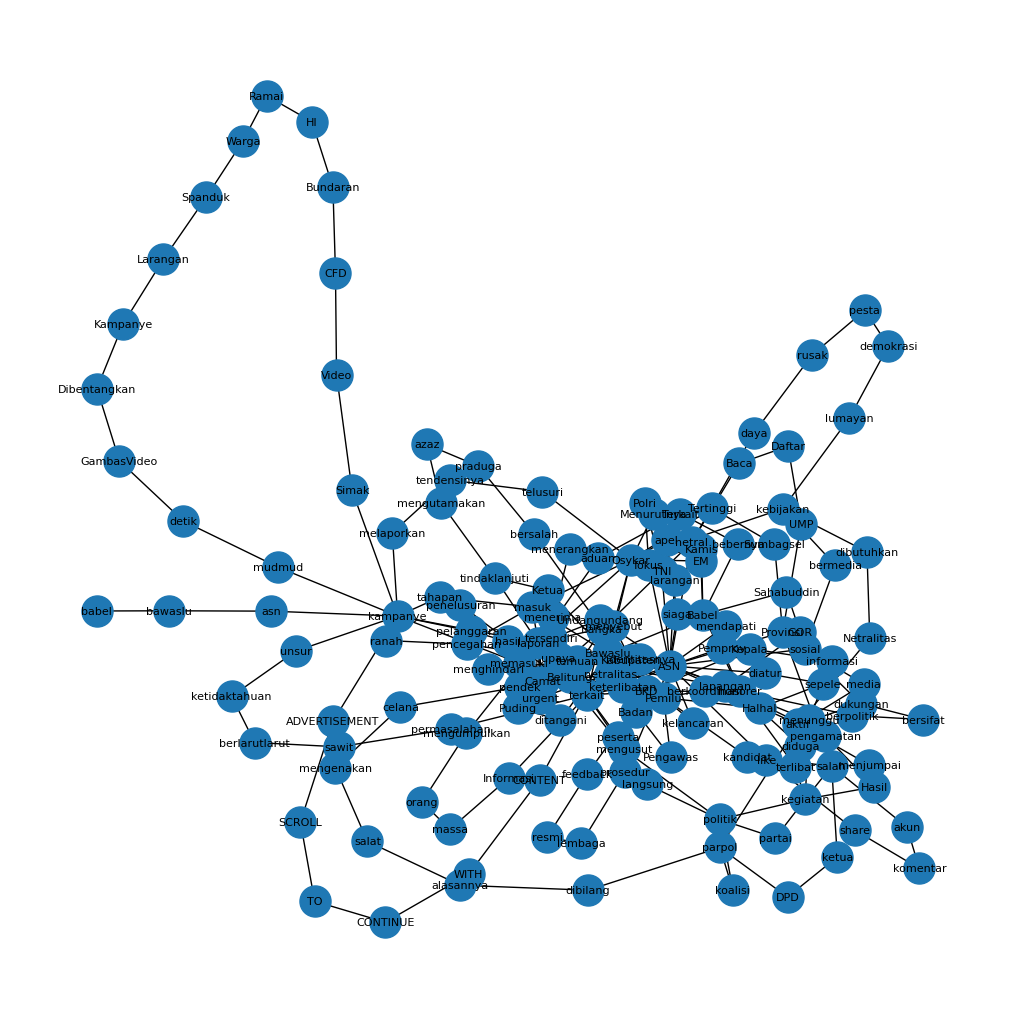

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the DataFrame to a networkx graph
G = nx.from_pandas_adjacency(coo_df)

# Visualize the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=500, font_color='black')
plt.show()

## Closeness, Eigenvector, Pagerank, Betweenness Centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
pagerank_centrality = nx.pagerank(G)
betweenness_centrality = nx.pagerank(G)

## Closeness Centrality

Closeness centrality adalah sebuah metrik dalam analisis jaringan yang mengukur seberapa cepat suatu simpul (node) dapat diakses oleh simpul-simpul lain dalam jaringan. Dalam konteks graf, closeness centrality didefinisikan sebagai invers dari total jarak terpendek dari simpul tersebut ke semua simpul lainnya dalam jaringan. Dengan kata lain, simpul dengan closeness centrality yang tinggi berarti lebih mudah diakses atau lebih dekat secara struktural dengan simpul-simpul lainnya dalam jaringan.

Formula closeness centrality untuk simpul  dalam sebuah graf terhubung adalah sebagai berikut:
$C(u) = \frac{1}{\sum_{v=1}^{n} d(u, v)}$


Dimana:

- $C(u)$ adalah closeness centrality dari node $u$


- $d(u,v)$  adalah jarak terpendek antara node $u$ dan $v$

In [ ]:
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Closeness Similarity Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_closeness:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_closeness[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Closeness Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")

Closeness Similarity Scores (Dari Tertinggi ke Terendah):
ASN: 0.36705882352941177
laporan: 0.3577981651376147
terkait: 0.3305084745762712
temuan: 0.3183673469387755
Pemilu: 0.3151515151515151
Osykar: 0.2988505747126437
kampanye: 0.29714285714285715
Bawaslu: 0.2905027932960894
Kabupaten: 0.2894248608534323
aktif: 0.28888888888888886
lapangan: 0.2878228782287823
masuk: 0.287292817679558
honorer: 0.287292817679558
netral: 0.28363636363636363
menyebut: 0.2815884476534296
Pemprov: 0.2810810810810811
Provinsi: 0.2805755395683453
Bangka: 0.2800718132854578
identitasnya: 0.27906976744186046
keterlibatan: 0.27906976744186046
netralitas: 0.2775800711743772
mendapati: 0.27708703374777977
kelancaran: 0.2761061946902655
sosial: 0.2761061946902655
Camat: 0.2756183745583039
larangan: 0.2751322751322751
mengusut: 0.2736842105263158
pendek: 0.27225130890052357
upaya: 0.27225130890052357
like: 0.271304347826087
prosedur: 0.271304347826087
memasuki: 0.2708333333333333
diatur: 0.2703639514731369
tindakla

## Pagerank Centrality


PageRank centrality adalah suatu metode untuk mengukur pentingnya simpul (node) dalam suatu jaringan berbasis graf. Metode ini awalnya dikembangkan oleh Larry Page dan Sergey Brin untuk menilai relevansi halaman web dalam mesin pencari Google, dan kemudian diadopsi dalam analisis jaringan umumnya. PageRank centrality mengukur seberapa penting atau otoritatif suatu simpul dengan memperhitungkan jumlah dan kualitas koneksi yang dimilikinya. Intinya, simpul-simpul yang dihubungkan dengan simpul lain yang juga memiliki keterhubungan yang tinggi akan mendapatkan skor PageRank yang lebih tinggi.



Rumus umum untuk menghitung nilai PageRank  dalam sebuah graf adalah:
$PR(A) = (1-d) + d \left( \frac{PR(T1)}{C(T1)} + \frac{PR(T2)}{C(T2)} + ... + \frac{PR(Tn)}{C(Tn)} \right)$



- $PR(A)$ adalah PageRank dari halaman $A$.

- $PR(T1)$ sampai $PR(Tn)$ adalah PageRank dari halaman $T1$ sampai $Tn$ yang mengarah ke halaman $A$ (yaitu halaman yang memiliki tautan ke $A$).

- $C(T1)$ sampai $C(Tn)$ adalah jumlah tautan keluar dari halaman $T1$ sampai $Tn$.

- $d$ adalah faktor damping, yang biasanya diatur ke 0.85.

berikut contoh hitung manual dari pagerank :
https://docs.google.com/spreadsheets/d/1v-Xs-6sDeWFsMoIyW-Jj5Tc70aHMDN4emdDBugFYykM/edit?usp=sharing

In [ ]:
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)

print("Pagerank Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_pagerank:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_pagerank[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Pagerank Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")

Pagerank Scores (Dari Tertinggi ke Terendah):
ASN: 0.04927850750550601
laporan: 0.030170358492548368
terkait: 0.024798701009735347
kampanye: 0.02277107132925995
Osykar: 0.019958645609434545
Pemilu: 0.01691468966563058
Babel: 0.015700193532113205
Bawaslu: 0.01561537692183833
honorer: 0.015016809702231536
Bangka: 0.014498423760107185
aktif: 0.013840845771591986
kegiatan: 0.012623719758510376
temuan: 0.012282008922750918
salah: 0.011266523307672296
BKD: 0.010235121046956041
lapangan: 0.00995276763026735
politik: 0.009894397846169432
masuk: 0.009471248213144571
parpol: 0.00830548395410689
kebijakan: 0.008260233339125789
Provinsi: 0.007727641797943821
netral: 0.007707492884993505
sosial: 0.007303690440128633
pencegahan: 0.007285761032939911
dukungan: 0.007233528480497211
tindaklanjuti: 0.0070834038112164
menunggu: 0.006971609723544894
hasil: 0.006872030676350213
menerima: 0.006730975342610678
Puding: 0.006502682183964374
netralitas: 0.006486932282561414
menyebut: 0.0064800518873312
terlibat

## Eigenvector Centrality

Eigenvector centrality adalah metode pengukuran kepentingan simpul dalam suatu jaringan yang mempertimbangkan kualitas koneksi dari simpul tersebut. Pendekatan ini memberikan bobot yang lebih tinggi pada simpul yang terhubung dengan simpul-simpul lain yang juga memiliki kepentingan tinggi. Dengan kata lain, simpul dengan eigenvector centrality yang tinggi tidak hanya memiliki banyak koneksi, tetapi juga terhubung dengan simpul-simpul penting dalam jaringan.

Eigenvector centrality dihitung berdasarkan nilai eigen dari matriks adjasensi atau matriks berbobot yang merepresentasikan struktur jaringan. Nilai eigen ini memberikan informasi tentang distribusi kepentingan simpul dalam jaringan. Simpul dengan nilai eigen yang tinggi cenderung terhubung dengan simpul-simpul lain yang juga memiliki nilai eigen yang tinggi.

Rumus umum untuk menghitung eigenvector centrality dalam suatu jaringan adalah sebagai berikut:

$x_v = \frac{1}{\lambda} \sum_{t \in M(v)} x_t$


- $x_v$ adalah eigenvector centrality dari simpul $v$.

- $M(v)$ adalah set simpul yang berdekatan dengan $v$

- $x_t$​ adalah eigenvector centrality dari simpul $t$.

- λ adalah konstanta.

In [ ]:
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

print("Eigenvector Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_eigenvector:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_eigenvector[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi Pagerank Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")


Eigenvector Scores (Dari Tertinggi ke Terendah):
ASN: 0.5267919626666535
laporan: 0.3089080858165924
terkait: 0.29948982991203527
temuan: 0.2329486132386822
Pemilu: 0.1880912524157427
lapangan: 0.16573916117089832
Osykar: 0.14014593013262688
Bawaslu: 0.13593065087613201
honorer: 0.13349037202573671
identitasnya: 0.13007727007279504
keterlibatan: 0.13007727007279504
Bangka: 0.1298857057324913
Kabupaten: 0.1247773268776425
Pemprov: 0.11869461195634685
kelancaran: 0.1125399780881199
aktif: 0.11047889675877963
netral: 0.10898030399845336
netralitas: 0.10889113348406176
masuk: 0.10304169874729034
menyebut: 0.09913142379802435
mendapati: 0.09768007935451486
sosial: 0.09646473232425538
Babel: 0.09369545254968976
Provinsi: 0.09276740244125732
Undangundang: 0.09264798909647877
upaya: 0.08924443416626011
larangan: 0.08859928889955873
TNI: 0.08725439039244968
fokus: 0.08725439039244968
hasil: 0.08594979869910838
diatur: 0.08586414545203286
prosedur: 0.08514107839450115
like: 0.0851124136228654
pe

## Betweenes Centrality


Betweenness centrality adalah metode pengukuran kepentingan simpul dalam suatu jaringan berbasis graf yang mengukur seberapa sering suatu simpul menjadi perantara (intermediary) pada lintasan terpendek antara dua simpul lain dalam jaringan. Dengan kata lain, simpul dengan betweenness centrality yang tinggi cenderung memiliki peran penting dalam menghubungkan bagian-bagian yang berbeda dalam jaringan.
rumusnya sebagai berikut:

$C_B(v) =\sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)}$

Dimana:

- $C_B​(v)$ adalah betweenness centrality dari simpul $v$

- $V$ adalah set simpul dalam jaringan

- $σ(s,t)$ adalah jumlah shortest path dari simpul $s$ ke simpul $t$

- $σ(s,t∣v)$ adalah jumlah shortest path dari simpul $s$ ke simpul $t$ yang melewati simpul $v$

In [ ]:
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

print("betweenness Scores (Dari Tertinggi ke Terendah):")
for node, score in sorted_betweenness:
    print(f"{node}: {score}")

# Tampilkan 3 kata teratas dari nilai tertinggi
top_3_nodes = sorted_betweenness[:3]

print("Tiga Kata Teratas dari Nilai Tertinggi betweenness Centrality:")
for node, _ in top_3_nodes:
    print(f"Kata: {node}")


betweenness Scores (Dari Tertinggi ke Terendah):
ASN: 0.04927850750550601
laporan: 0.030170358492548368
terkait: 0.024798701009735347
kampanye: 0.02277107132925995
Osykar: 0.019958645609434545
Pemilu: 0.01691468966563058
Babel: 0.015700193532113205
Bawaslu: 0.01561537692183833
honorer: 0.015016809702231536
Bangka: 0.014498423760107185
aktif: 0.013840845771591986
kegiatan: 0.012623719758510376
temuan: 0.012282008922750918
salah: 0.011266523307672296
BKD: 0.010235121046956041
lapangan: 0.00995276763026735
politik: 0.009894397846169432
masuk: 0.009471248213144571
parpol: 0.00830548395410689
kebijakan: 0.008260233339125789
Provinsi: 0.007727641797943821
netral: 0.007707492884993505
sosial: 0.007303690440128633
pencegahan: 0.007285761032939911
dukungan: 0.007233528480497211
tindaklanjuti: 0.0070834038112164
menunggu: 0.006971609723544894
hasil: 0.006872030676350213
menerima: 0.006730975342610678
Puding: 0.006502682183964374
netralitas: 0.006486932282561414
menyebut: 0.0064800518873312
terli